In [1]:
from keras.preprocessing.text import Tokenizer
samples=['The cat sat on the mat.','The dog ate my homework.']
tokenizer=Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)
sequences=tokenizer.texts_to_sequences(samples)
one_hot_results=tokenizer.texts_to_matrix(samples,mode='binary')
word_index=tokenizer.word_index
print('found %s unique tokens'%len(word_index))

Using TensorFlow backend.


found 9 unique tokens


In [9]:
import numpy as np
dimention=1000
max_length=10
results=np.zeros((len(samples),max_length,dimention))
for i,sample in enumerate(samples):
    for j,word in list(enumerate(sample.split()))[:max_length]:
        print(hash(word))
        index=abs(hash(word))%dimention
        results[i,j,index]=1
        
    ##one hot with hashing

-6111975567781923932
-4435904934480689877
-373982119594502451
-307049303262528404
-5766143069052625729
2875397608848641686
-6111975567781923932
589095979881575606
-5113082439761682902
8965404611349458444
7482818159745935918


In [7]:
from keras.layers import Embedding
embedding_layer=Embedding(1000,64)#1000 possible tokens, 64 dimension

[(0, 'The'), (1, 'doog'), (2, 'ate'), (3, 'my'), (4, 'homework.')]

In [11]:
from keras.datasets import imdb
from keras import preprocessing
max_features=10000
maxlen=20
(x_train,y_train),(x_test,y_test)=imdb.load_data(num_words=max_features)
x_train=preprocessing.sequence.pad_sequences(x_train,maxlen=maxlen)
x_test=preprocessing.sequence.pad_sequences(x_test,maxlen=maxlen)

In [14]:
from keras.models import Sequential
from keras.layers import Flatten,Dense
from keras.layers import Embedding
model=Sequential()
model.add(Embedding(10000,8,input_length=maxlen))
model.add(Flatten())## (samples,maxlen*8)
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [15]:
history=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 4s 196us/step - loss: 0.6661 - acc: 0.6279 - val_loss: 0.6128 - val_acc: 0.6996
Epoch 2/10
20000/20000 [==============================] - 2s 82us/step - loss: 0.5378 - acc: 0.7509 - val_loss: 0.5231 - val_acc: 0.7314
Epoch 3/10
20000/20000 [==============================] - 2s 82us/step - loss: 0.4607 - acc: 0.7863 - val_loss: 0.4980 - val_acc: 0.7454
Epoch 4/10
20000/20000 [==============================] - 2s 82us/step - loss: 0.4220 - acc: 0.8091 - val_loss: 0.4925 - val_acc: 0.7536
Epoch 5/10
20000/20000 [==============================] - 2s 81us/step - loss: 0.3944 - acc: 0.8261 - val_loss: 0.4917 - val_acc: 0.7558
Epoch 6/10
20000/20000 [==============================] - 2s 81us/step - loss: 0.3722 - acc: 0.8386 - val_loss: 0.4958 - val_acc: 0.7564
Epoch 7/10
20000/20000 [==============================] - 2s 82us/step - loss: 0.3517 - acc: 0.8506 - val_loss: 0.4987 - val_acc

In [18]:
import os
imdb_dir=r'D:\Cdeepmachine\Imdb'
train_dir=os.path.join(imdb_dir,'train')
labels=[]
texts=[]
for label_type in ['neg','pos']:
    dir_name=os.path.join(train_dir,label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:]=='.txt':
            f=open(os.path.join(dir_name,fname),encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type=='neg':
                labels.append(0)
            else:
                labels.append(1)

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen=100  #cut off point
training_samples=200
validation_samples=10000
max_words=10000
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences=tokenizer.texts_to_sequences(texts)
word_index=tokenizer.word_index
print('found %s unique tokens'%len(word_index))

found 88582 unique tokens


In [25]:
data=pad_sequences(sequences,maxlen=maxlen)
labels=np.asarray(labels)
print('shape of data tensor',data.shape)
print('shape of label tensor', labels.shape)


shape of data tensor (25000, 100)
shape of label tensor (25000,)


In [26]:
indices=np.arange(data.shape[0])
np.random.shuffle(indices)
data=data[indices]
labels=labels[indices] #shuffle

In [28]:
x_train=data[:training_samples]
y_train=labels[:training_samples]
x_val=data[training_samples:training_samples+validation_samples]
y_val=labels[training_samples:training_samples+validation_samples]

In [32]:
#parse glove dictionary
glove_dir=r'D:\Cdeepmachine'
embeddings_index={}
f=open(os.path.join(glove_dir,'glove.6B.100d.txt'),encoding="utf8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeddings_index[word]=coefs
f.close()
print('found %s word vectors' %len(embeddings_index))

found 400000 word vectors


In [33]:
# build embedding matrix (max_words,embedding_dim), index 0 place holder
embedding_dim=100
embedding_matrix=np.zeros((max_words,embedding_dim))
for word,i in word_index.items():
    if i<max_words:
        embedding_vector=embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector

In [34]:
#build model
model=Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Flatten())## (samples,maxlen*8)
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [35]:
#load matrix
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable=False

In [36]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_val,y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 1.1867 - acc: 0.5150 - val_loss: 0.8813 - val_acc: 0.4999
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5628 - acc: 0.6850 - val_loss: 0.9373 - val_acc: 0.4992
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5116 - acc: 0.7500 - val_loss: 0.7536 - val_acc: 0.4988
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3689 - acc: 0.8450 - val_loss: 0.8186 - val_acc: 0.4968
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3031 - acc: 0.9000 - val_loss: 1.0071 - val_acc: 0.5002
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2468 - acc: 0.9400 - val_loss: 2.3182 - val_acc: 0.5003
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.2653 - acc: 0.9200 - val_loss: 1.0357 - val_acc: 0.4976
Epoch 8/10
200/200 [========

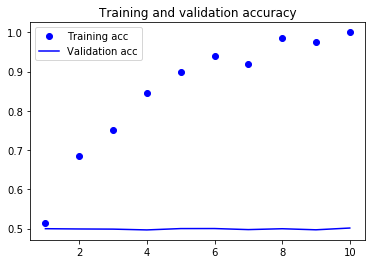

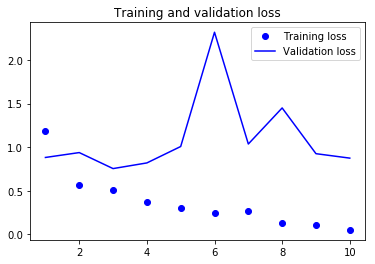

In [37]:
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [38]:
#train same model without pretrained embeddings
model=Sequential()
model.add(Embedding(max_words,embedding_dim,input_length=maxlen))
model.add(Flatten())## (samples,maxlen*8)
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
history=model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_val,y_val))
#pretrain better

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6981 - acc: 0.4100 - val_loss: 0.6938 - val_acc: 0.5008
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5271 - acc: 0.9950 - val_loss: 0.6988 - val_acc: 0.4997
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3219 - acc: 1.0000 - val_loss: 0.7062 - val_acc: 0.4950
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1389 - acc: 1.0000 - val_loss: 0.7158 - val_acc: 0.4962
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0649 - acc: 1.0000 - val_loss: 0.7253 - val_acc: 0.4984
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0334 - acc: 1.0000 - val_loss: 0.7245 - val_acc: 0.4979
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.0180 - acc: 1.0000 - val_loss: 0.7305 - val_acc: 0.4975
Epoch 8/10
200/200 [========

In [42]:
#test data
test_dir=os.path.join(imdb_dir,'test')
labels=[]
texts=[]
for label_type in ['neg','pos']:
    dir_name=os.path.join(test_dir,label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:]=='.txt':
            f=open(os.path.join(dir_name,fname),encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type=='neg':
                labels.append(0)
            else:
                labels.append(1)

In [43]:
sequences=tokenizer.texts_to_sequences(texts)
x_test=pad_sequences(sequences,maxlen=maxlen)
y_test=np.asarray(labels)

In [44]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 1s 40us/step


[0.8621112065982819, 0.50688]